In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pylsd
from pylsd.pylsd.pylsd.lsd import *
from PIL import Image
import tools
import time
import psutil

In [16]:
def show_info(self):
    #计算消耗内存
    pid = os.getpid()
    # 模块名比较容易理解：获得当前进程的pid
    p = psutil.Process(pid)
    # 根据pid找到进程，进而找到占用的内存值
    info = p.memory_full_info()
    memory = info.uss / 1024 / 1024
    return memory
    # print(f'{start} 一共占用{memory:.2f}MB')

In [17]:
start_memory=show_info('开始')

In [18]:
def imgBrightness(img1, c, b): 
    rows, cols, channels = img1.shape
    blank = np.zeros([rows, cols, channels], img1.dtype)
    rst = cv2.addWeighted(img1, c, blank, 1-c, b)
    return rst

In [19]:
def get_mask(img, kp):
    x,y,_ = img.shape
    mask = np.zeros((x,y))
    for k in kp:
        mask[k[0]-1][k[1]-1] = 1
    return mask

In [20]:
def line_det(img):
    kp=[]
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray,(5,5),5)
    linesL = lsd(gray)
    for line in linesL:
        x1, y1, x2, y2 = map(int,line[:4])
        kp.append((y1, x1))
        kp.append((y2, x2))
#         kp.append((y1+(y2-y1)//2, x1+(x2-x1)//2))
    mask = get_mask(img, kp)
    line_mask = cv2.dilate(mask, np.ones((25, 25), np.uint8))
    return line_mask, kp

In [21]:
a = time.time()

In [23]:
path = 'C:/Users/www65/line_matching/data/rs/01.png'
path1 = 'C:/Users/www65/line_matching/data/rs/01-2.png'
# path = r'D:\Learn\database\HRSC\HRSC\HRSC2016\FullDataSet\AllImages\100000001.bmp'
# path1 = r'D:\Learn\database\HRSC\HRSC\HRSC2016\FullDataSet\AllImages\100000002.bmp'
# path = 'C:/Users/www65/line_matching/data/rs_thesis/5.png'
# path1 = 'C:/Users/www65/line_matching/data/rs_thesis/5-2.png'

In [24]:
img = cv2.imread(path)
# img1 = cv2.imread(path1)
dst1 = imgBrightness(img, 0.5, 0)  #变暗
dst2 = imgBrightness(img, 1.5, 0)  #变亮
# dst2 = cv2.GaussianBlur(dst2,(11,11),1.3)
plt.imsave("C:/Users/www65/line_matching/data/rs_thesis/5-3.png", cv2.cvtColor(dst2, cv2.COLOR_BGR2RGB))

In [25]:
img = cv2.imread(path)
# img1 = cv2.imread(path1)
M1 = cv2.getRotationMatrix2D((img.shape[1]/2,img.shape[0]/2),90,1)
dst1 = cv2.warpAffine(img,M1,(img.shape[1],img.shape[0]))
M2 = cv2.getRotationMatrix2D((img.shape[1]/2,img.shape[0]/2),45,1)
dst2 = cv2.warpAffine(img,M2,(img.shape[1],img.shape[0]))
# cv2.imwrite('C:/Users/www65/line_matching/data/rs_thesis/5-4.png', dst2)

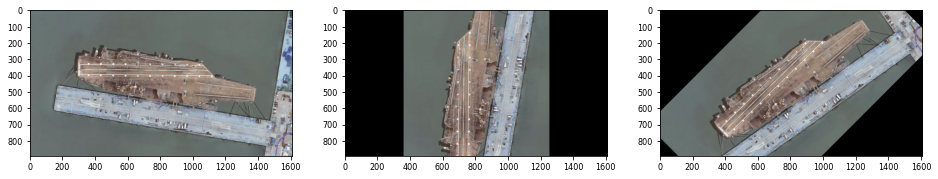

In [26]:
plt.rcParams['figure.figsize'] = (16, 16)
plt.rcParams['font.size'] = 8
plt.subplot(131)
plt.imshow(img)
# plt.imsave("C:/Users/www65/line_matching/data/rs/05-1.png", cv2.cvtColor(dst1, cv2.COLOR_BGR2RGB))
plt.subplot(132)
plt.imshow(dst1)
plt.subplot(133)
plt.imshow(dst2)
# plt.imsave("C:/Users/www65/line_matching/data/rs/294-1.", cv2.cvtColor(dst2, cv2.COLOR_BGR2RGB))

In [27]:
len(img)

892

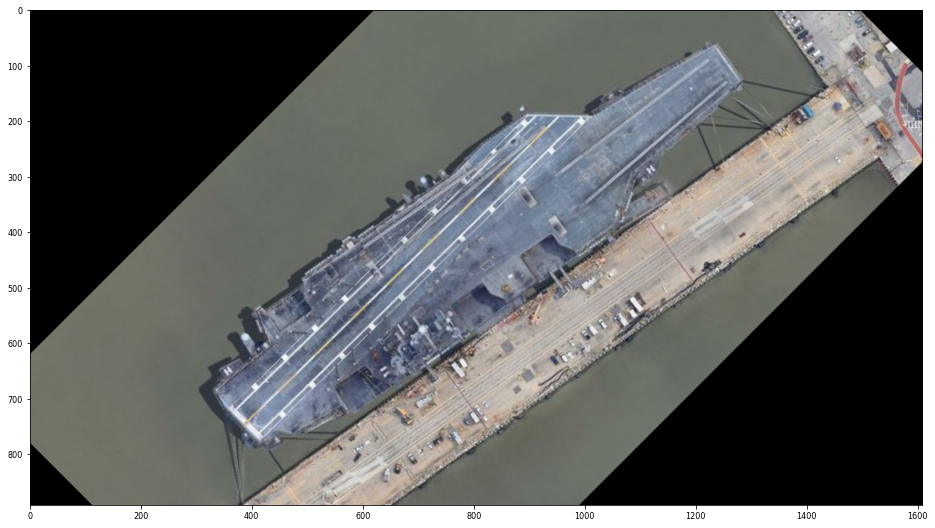

In [28]:
# plt.axis('off')
plt.imshow(cv2.cvtColor(dst2, cv2.COLOR_BGR2RGB))
# plt.savefig(r'C:/Users/www65/line_matching/data/rs/294-1.jpg', dpi=96, bbox_inches='tight',pad_inches = 0)

In [29]:
line_mask, kp = line_det(img)
line_mask1, kp1 = line_det(dst1)
line_mask2, kp2 = line_det(dst2)

In [30]:
sifter = cv2.SIFT_create(100000000, contrastThreshold=-10000,edgeThreshold=-10000)

In [31]:
kps, desc = sifter.detectAndCompute(img, None)
kps1, desc1 = sifter.detectAndCompute(dst1, None)
kps2, desc2 = sifter.detectAndCompute(dst2, None)

In [32]:
matcher = cv2.BFMatcher()

In [33]:
raw_matches1 = matcher.knnMatch(desc, desc1, k = 2)
good_matches1 = []
pt1_1 = []
pt2_1 = []
for m1, m2 in raw_matches1:
    if m1.distance < 0.85 * m2.distance:
        pt1_1.append(kps[m1.queryIdx].pt)
        pt2_1.append(kps2[m1.trainIdx].pt)
        good_matches1.append([m1])

In [34]:
def cal_rep_(pt1, pt2, H, good_matches):
    count = 0
    for i in range (len(good_matches)):
        x1 = pt1[i]
        x2 = pt2[i]
        x_1to2 = np.dot(H, np.insert(np.array(x1).copy(),  2, 1, axis=0).T)
        d = np.sqrt((x_1to2[0]-x2[0])**2 + (x_1to2[1]-x2[1])**2)
        if (d <1.5):
            count = count + 1
#     print(count)
    rep = count / len(good_matches)
    return rep

In [36]:
ptsA_1= np.float32([kps[m[0].queryIdx].pt for m in good_matches1]).reshape(-1, 1, 2)
ptsB_2 = np.float32([kps1[m[0].trainIdx].pt for m in good_matches1]).reshape(-1, 1, 2)
H1, mask = cv2.findHomography(ptsA_1, ptsB_2, cv2.RANSAC, 5.0)

In [37]:
len(good_matches1)

12191

# 

In [38]:
matches1 = cv2.drawMatchesKnn(img.copy(), kps, dst1.copy(), kps1, good_matches1, None, flags = 2)

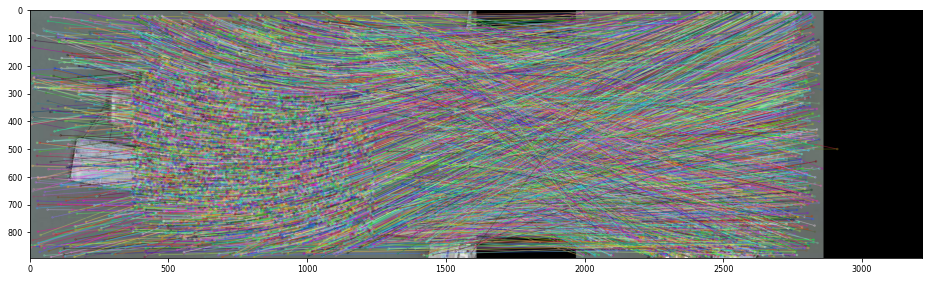

In [39]:
plt.figure()
plt.imshow(matches1)

In [40]:
end_memory=show_info('结束')

In [41]:
end_memory-start_memory

211.00390625

In [683]:
b = time.time()

In [684]:
b-a

5122.6215007305145

In [763]:
raw_matches2 = matcher.knnMatch(desc, desc2, k = 2)
good_matches2 = []
pt1 = []
pt2 = []
for m1, m2 in raw_matches2:
    if m1.distance < 0.85 * m2.distance:
        pt1.append(kps[m1.queryIdx].pt)
        pt2.append(kps2[m1.trainIdx].pt)
#         print(pt1,pt2)
        good_matches2.append([m1])

In [764]:
matches2 = cv2.drawMatchesKnn(img.copy(), kps, dst2.copy(), kps2, good_matches2, None, flags = 2)

In [765]:
ptsA= np.float32([kps[m[0].queryIdx].pt for m in good_matches2]).reshape(-1, 1, 2)
ptsB = np.float32([kps2[m[0].trainIdx].pt for m in good_matches2]).reshape(-1, 1, 2)
H2, mask = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, 5.0)

In [766]:
len(good_matches2)

17408

In [767]:
cal_rep(pt1, pt2, H2, good_matches2)

count= 16096
rep= 0.9246323529411765


(0.9246323529411765,
 [(5.844878196716309,
   586.6331787109375,
   18.032249450683594,
   423.7803039550781),
  (12.084630966186523, 81.78852844238281, 28.12114715576172, 84.8941421508789),
  (15.777860641479492,
   282.354736328125,
   192.79617309570312,
   41.62327194213867),
  (21.136184692382812,
   307.0177917480469,
   279.03314208984375,
   276.2090148925781),
  (21.136184692382812, 307.0177917480469, 794.8408203125, 755.6670532226562),
  (22.501358032226562, 778.1358642578125, 9.3282470703125, 769.3464965820312),
  (24.879308700561523,
   47.617088317871094,
   188.33706665039062,
   706.2854614257812),
  (40.219844818115234,
   66.23477935791016,
   40.279701232910156,
   64.67020416259766),
  (41.96864318847656, 245.07373046875, 139.81959533691406, 323.58245849609375),
  (42.0396728515625, 670.999755859375, 39.52983856201172, 670.890380859375),
  (50.52372360229492, 29.92794418334961, 391.9696350097656, 77.1296615600586),
  (57.5101318359375, 440.6083679199219, 346.17129516

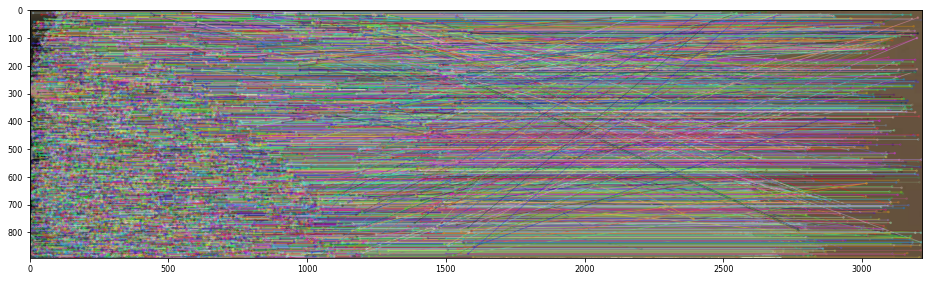

In [768]:
plt.figure()
plt.imshow(matches2)

In [769]:
end_m = show_info()

In [770]:
end_m-start_m

391.828125

In [290]:
c = time.time()

In [ ]:
c-a

# deep learning

In [103]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"

In [43]:
# coding=utf-8
import tools
import cv2
import os
import numpy as np
import pickle
from tqdm import tqdm
import h5py
import torch
import torch.utils
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pydegensac as pyransac
import torch.nn as nn
from hardnet_retrain import HardNet
import dill
import time
from pylsd.pylsd.pylsd.lsd import *

In [44]:
a_d = time.time()

In [64]:
start_memory=show_info('开始')

In [65]:
path1 = 'C:/Users/www65/line_matching/data/rs_thesis/4.png'
path2 = 'C:/Users/www65/line_matching/data/rs_thesis/4-2.png'

In [66]:
sifter = cv2.SIFT_create(100000000, contrastThreshold=-10000,edgeThreshold=-10000)

In [67]:
device = torch.device('cpu')
model = HardNet() #changed
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load("./model/Hardnet_retrain_myloader/9.h5", map_location=device)['net'])   #changed
model = model.module
model.eval()
# model.cuda()
model = torch.nn.DataParallel(model)

C:\Users\www65\line_matching\hardnet_retrain.py:38: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(m.weight.data, gain=0.6)


In [68]:
def get_transforms():
    MEAN_IMAGE = 0.443728476019
    STD_IMAGE = 0.20197947209
    transform = transforms.Compose([
        transforms.Lambda(lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)),
        transforms.Lambda(lambda x: x.reshape(32, 32, 1)),    
        transforms.ToTensor(),          
        transforms.Normalize((MEAN_IMAGE, ), (STD_IMAGE, ))
    ])
    return transform

In [69]:
def compute_patch_mat(kp, size, angle, patch_size=32, factor=12):
    x, y = kp
    scale = factor * size / patch_size
    offset_mat = np.array([(1, 0, patch_size / 2 - x), (0, 1, patch_size / 2 - y)], 'float32')
    rotate_mat = cv2.getRotationMatrix2D((x, y), 0, 1 / scale)
    M = np.matmul(offset_mat, np.concatenate([rotate_mat, [[0, 0, 1]]]))
    return M

In [70]:
def extract_img(img, patch_size=32, factor=10, keep_size=8000):
    kps = sifter.detect(img)
    img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    scores = np.array([i.response for i in kps])
    sorted_arg = np.argsort(scores)[::-1][:keep_size]
    scores = scores[sorted_arg]
    sizes = np.array([i.size for i in kps])[sorted_arg]
    angles = np.array([i.angle for i in kps])[sorted_arg]
    kps = np.array([i.pt for i in kps])[sorted_arg]
    patches = []
    for kp, size, angle in zip(kps, sizes, angles):
        M = compute_patch_mat(kp, size, angle, patch_size, factor)
        patches.append(cv2.warpAffine(img, M, (patch_size, patch_size), 
                                      flags=cv2.INTER_LINEAR + cv2.WARP_FILL_OUTLIERS,
                                      borderMode=cv2.BORDER_REPLICATE))
    return np.array(patches), kps, scores

In [71]:
def get_desc(patches):
    descs = []
    for i in range(0, len(patches), 256):
        data = patches[i:i + 256]
        features = model(data)
        descs += features.detach().cpu().numpy().tolist()
    return descs

In [72]:
img1 = cv2.imread(path1)
img2 = cv2.imread(path2)
# mask1 = np.ones((img1.shape[0], img1.shape[1]))
# mask2 = np.ones((img2.shape[0], img2.shape[1]))

In [73]:
patches1, kps1, scores1 = extract_img(img1)
patches2, kps2, scores2 = extract_img(img2)

In [74]:
patches1 = torch.stack([get_transforms()(x) for x in patches1])
patches2 = torch.stack([get_transforms()(y) for y in patches2])
desc1 = get_desc(patches1)
desc2 = get_desc(patches2)

In [75]:
desc1 = np.array(desc1).astype(np.float32)
desc2 = np.array(desc2).astype(np.float32)

In [76]:
match_pair = tools.get_matches(desc1, desc2) 
match_kp1 = kps1[match_pair[:, 0]]
match_kp2 = kps2[match_pair[:, 1]]

H, mask = pyransac.findHomography(match_kp1, match_kp2)

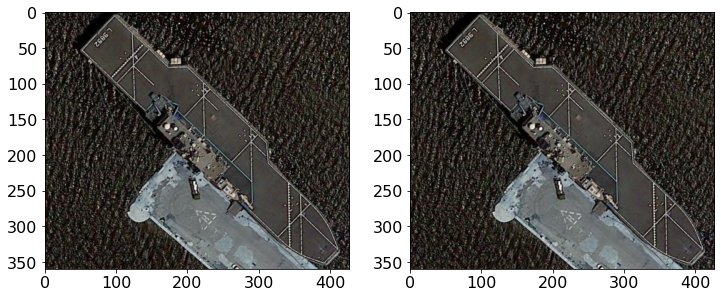

In [77]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (12, 12)
plt.subplot(121)
plt.imshow(cv2.warpPerspective(img1, H, img2.shape[:2][::-1]))
plt.subplot(122)
plt.imshow(img2)

In [78]:
res = tools.drawMatches(img1, img2, match_kp1, match_kp2)
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)

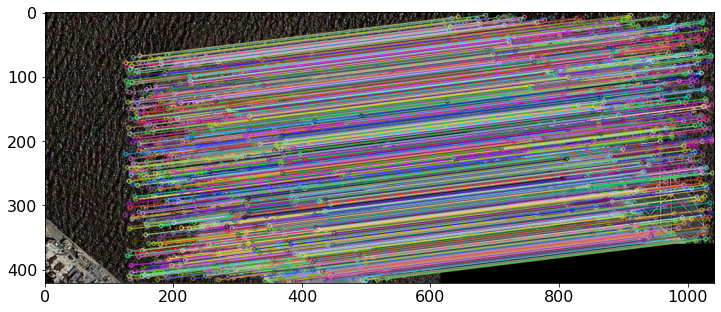

In [79]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (12, 12)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

In [80]:
end_memory=show_info('结束')

In [81]:
end_memory-start_memory

-33.3125

In [83]:
end_memory

351.46484375

In [789]:
start_m_d

434.0390625

In [790]:
b_d = time.time() 

In [791]:
b_d-a_d

11049.161499500275

In [792]:
def cal_rep(pt1, pt2, H, good_matches):
    count = 0
    wrong = []
    for i in range (len(good_matches)):
        x1 = pt1[i]
        x2 = pt2[i]
        x_1to2 = np.dot(H, np.insert(np.array(x1).copy(),  2, 1, axis=0).T)
        d = np.sqrt((x_1to2[0]-x2[0])**2 + (x_1to2[1]-x2[1])**2)
        if (d < 1.5):
            count = count + 1
        else:
            wrong.append((x1[0],x1[1],x2[0],x2[1]))
    print("count=",count)
    rep = count / len(good_matches)
    print("rep=",rep)
    return rep, wrong

In [793]:
H_d, mask = cv2.findHomography(match_kp1, match_kp2, cv2.RANSAC, 5.0)

In [794]:
H_d

array([[ 9.99917923e-01, -1.29271280e-05,  1.47182066e-02],
       [-3.99918830e-05,  9.99960600e-01,  9.05889666e-03],
       [-9.46118076e-08, -2.02394506e-08,  1.00000000e+00]])

In [795]:
len(match_pair)

4742

In [796]:
rep, wrong = cal_rep(match_kp1, match_kp2, H_d, match_pair)

count= 4694
rep= 0.9898776887389287


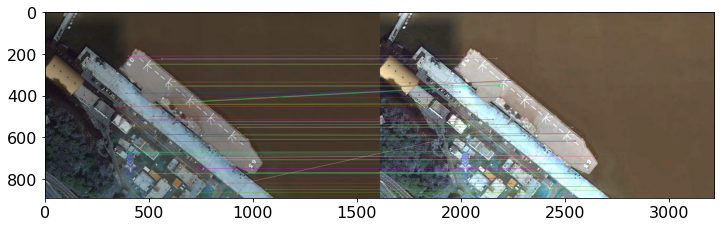

In [797]:
res = tools.drawMatches(img1, img2, np.array(wrong)[:,0:2], np.array(wrong)[:,2:4])  #错误的匹配点
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))